In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
tb.__version__

'0.0.3.13'

In [3]:
EXPERIMENT_NAME = '1122-Scene3-LSTM-SmallWindow-UseD'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene1_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene1_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [4]:
WINDOW_SIZE = 48

In [5]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z',
                      'dyaw', 'dpitch', 'droll']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [6]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [7]:
len(ds_train), len(ds_test)

(18370, 19280)

In [8]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([48, 9]), torch.Size([3]))

In [9]:
x, y = ds_train[0]

In [10]:
x.shape

torch.Size([48, 9])

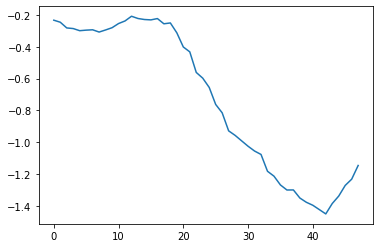

In [11]:
plt.plot(x[:, 2])

In [12]:
model = utils.BaselineLSTM(input_size=9,
                           hidden_size=64,
                           num_layers=8,
                           dropout=0.2,
                           bidirectional=True).cuda()

In [13]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [14]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [15]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [16]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [17]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.382254
 - Pitch        :  12.488091
 - Roll         :   3.084324
 - RMS          :   9.192245
 - 99% Tile     :  44.353708
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.042988
 - Pitch        :   9.498103
 - Roll         :   3.046780
 - RMS          :   7.773297
 - 99% Tile     :  40.544454
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   7.081442
 - Pitch        :   8.581997
 - Roll         :   2.998040
 - RMS          :   6.652963
 - 99% Tile     :  37.355325
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.824534
 - Pitch        :   6.768157
 - Roll         :   2.938151
 - RMS          :   5.427273
 - 99% Tile     :  33.431928
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.695200
 - Pitch        :   5.624100
 - Roll         :   2.948358
 - RMS          :   4.559540
 - 99% Tile     :  30.733633
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.285729
 - Pitch        :   4.912340
 - Roll         :   2.933048
 - RMS          :   4.127200
 - 99% Tile     :  28.244016
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.817462
 - Pitch        :   4.785285
 - Roll         :   2.927443
 - RMS          :   3.917562
 - 99% Tile     :  26.539356
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.167413
 - Pitch        :   4.008740
 - Roll         :   2.925614
 - RMS          :   3.399104
 - 99% Tile     :  24.699087
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.952300
 - Pitch        :   3.211538
 - Roll         :   2.825429
 - RMS          :   3.000728
 - 99% Tile     :  22.524317
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.500466
 - Pitch        :   2.859895
 - Roll         :   2.809256
 - RMS          :   2.727835
 - 99% Tile     :  20.634400
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.347017
 - Pitch        :   2.457490
 - Roll         :   2.853641
 - RMS          :   2.561966
 - 99% Tile     :  19.424200
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.051618
 - Pitch        :   2.330172
 - Roll         :   2.902176
 - RMS          :   2.453668
 - 99% Tile     :  18.100969
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.065781
 - Pitch        :   2.267824
 - Roll         :   2.875900
 - RMS          :   2.427707
 - 99% Tile     :  17.893988
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.860982
 - Pitch        :   1.803432
 - Roll         :   2.856504
 - RMS          :   2.226749
 - 99% Tile     :  17.260220
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.772993
 - Pitch        :   2.051951
 - Roll         :   2.782114
 - RMS          :   2.243076
 - 99% Tile     :  16.864738
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.634322
 - Pitch        :   1.709275
 - Roll         :   2.793274
 - RMS          :   2.113055
 - 99% Tile     :  16.444573
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.683402
 - Pitch        :   1.564434
 - Roll         :   2.802069
 - RMS          :   2.092278
 - 99% Tile     :  16.030947
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.438038
 - Pitch        :   1.621889
 - Roll         :   2.661753
 - RMS          :   1.981869
 - 99% Tile     :  16.010789
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.694647
 - Pitch        :   1.803044
 - Roll         :   2.261645
 - RMS          :   1.935444
 - 99% Tile     :  15.340994
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.601828
 - Pitch        :   1.619485
 - Roll         :   2.058726
 - RMS          :   1.772657
 - 99% Tile     :  15.050308
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.265877
 - Pitch        :   1.569340
 - Roll         :   1.971249
 - RMS          :   1.627994
 - 99% Tile     :  15.095119
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.139217
 - Pitch        :   1.455950
 - Roll         :   1.711611
 - RMS          :   1.454558
 - 99% Tile     :  13.812034
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.280763
 - Pitch        :   1.309555
 - Roll         :   1.546795
 - RMS          :   1.384180
 - 99% Tile     :  13.123876
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.201781
 - Pitch        :   1.351244
 - Roll         :   1.547899
 - RMS          :   1.374303
 - 99% Tile     :  13.981400
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.221795
 - Pitch        :   1.468175
 - Roll         :   1.371155
 - RMS          :   1.357496
 - 99% Tile     :  12.629244
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.308789
 - Pitch        :   1.375763
 - Roll         :   1.264059
 - RMS          :   1.317004
 - 99% Tile     :  11.973459
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.102579
 - Pitch        :   1.320771
 - Roll         :   1.216313
 - RMS          :   1.216488
 - 99% Tile     :  11.450693
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.201910
 - Pitch        :   1.236807
 - Roll         :   1.194795
 - RMS          :   1.211310
 - 99% Tile     :  11.426547
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.083335
 - Pitch        :   1.178697
 - Roll         :   1.277732
 - RMS          :   1.182588
 - 99% Tile     :  10.808040
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.059050
 - Pitch        :   1.245194
 - Roll         :   1.082271
 - RMS          :   1.131872
 - 99% Tile     :  10.802519
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.035266
 - Pitch        :   1.182843
 - Roll         :   1.109129
 - RMS          :   1.110715
 - 99% Tile     :  10.754410
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.038701
 - Pitch        :   1.188656
 - Roll         :   1.035858
 - RMS          :   1.090078
 - 99% Tile     :  10.608820
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.961845
 - Pitch        :   1.081430
 - Roll         :   1.074420
 - RMS          :   1.040675
 - 99% Tile     :  10.512414
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.037075
 - Pitch        :   1.038697
 - Roll         :   1.096973
 - RMS          :   1.057949
 - 99% Tile     :  10.401598
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.992077
 - Pitch        :   1.176220
 - Roll         :   1.036878
 - RMS          :   1.071265
 - 99% Tile     :   9.998867
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.065562
 - Pitch        :   0.984554
 - Roll         :   0.976433
 - RMS          :   1.009652
 - 99% Tile     :   9.931130
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.104219
 - Pitch        :   0.993938
 - Roll         :   0.967962
 - RMS          :   1.023745
 - 99% Tile     :   9.772353
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.060234
 - Pitch        :   1.078565
 - Roll         :   1.009176
 - RMS          :   1.049736
 - 99% Tile     :   9.839546
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.971667
 - Pitch        :   1.101869
 - Roll         :   0.958065
 - RMS          :   1.012611
 - 99% Tile     :   9.599611
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.955315
 - Pitch        :   1.054986
 - Roll         :   0.954799
 - RMS          :   0.989489
 - 99% Tile     :  10.281148
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.124136
 - Pitch        :   1.020308
 - Roll         :   0.912118
 - RMS          :   1.022525
 - 99% Tile     :   9.896347
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.241364
 - Pitch        :   1.164885
 - Roll         :   0.915642
 - RMS          :   1.115996
 - 99% Tile     :   9.630554
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.006945
 - Pitch        :   1.147024
 - Roll         :   0.881824
 - RMS          :   1.017713
 - 99% Tile     :   9.444844
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.902829
 - Pitch        :   0.981054
 - Roll         :   0.860707
 - RMS          :   0.916221
 - 99% Tile     :   9.626974
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.059776
 - Pitch        :   1.093085
 - Roll         :   0.885307
 - RMS          :   1.016813
 - 99% Tile     :   9.620345
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.040285
 - Pitch        :   1.073846
 - Roll         :   0.942692
 - RMS          :   1.020458
 - 99% Tile     :   9.614349
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.110242
 - Pitch        :   1.003495
 - Roll         :   0.845252
 - RMS          :   0.992319
 - 99% Tile     :   9.424465
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.039330
 - Pitch        :   0.940724
 - Roll         :   0.879298
 - RMS          :   0.955394
 - 99% Tile     :   9.561636
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.069975
 - Pitch        :   1.082307
 - Roll         :   0.925775
 - RMS          :   1.028477
 - 99% Tile     :   9.787064
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.902416
 - Pitch        :   0.913657
 - Roll         :   0.835543
 - RMS          :   0.884544
 - 99% Tile     :   9.385586
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.920236
 - Pitch        :   0.884963
 - Roll         :   0.821677
 - RMS          :   0.876574
 - 99% Tile     :   9.336524
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.929269
 - Pitch        :   0.991960
 - Roll         :   0.825682
 - RMS          :   0.918200
 - 99% Tile     :   9.451984
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.960778
 - Pitch        :   0.910451
 - Roll         :   0.814772
 - RMS          :   0.897379
 - 99% Tile     :   9.457538
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.963726
 - Pitch        :   0.963591
 - Roll         :   0.818466
 - RMS          :   0.917817
 - 99% Tile     :   9.477494
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.876761
 - Pitch        :   0.918520
 - Roll         :   0.813353
 - RMS          :   0.870619
 - 99% Tile     :   9.396104
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.979207
 - Pitch        :   1.011088
 - Roll         :   0.817862
 - RMS          :   0.939866
 - 99% Tile     :   9.447914
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0056.npy


[0058/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.871379
 - Pitch        :   0.974781
 - Roll         :   0.812900
 - RMS          :   0.888877
 - 99% Tile     :   9.296991
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0057.npy


[0059/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.912672
 - Pitch        :   0.920667
 - Roll         :   0.819517
 - RMS          :   0.885477
 - 99% Tile     :   9.159247
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0058.npy


[0060/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.895887
 - Pitch        :   0.896688
 - Roll         :   0.841053
 - RMS          :   0.878262
 - 99% Tile     :   9.060005
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0059.npy


[0061/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.991904
 - Pitch        :   0.934681
 - Roll         :   0.875113
 - RMS          :   0.935116
 - 99% Tile     :   9.272595
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0060.npy


[0062/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.987094
 - Pitch        :   1.051246
 - Roll         :   0.817982
 - RMS          :   0.957178
 - 99% Tile     :   9.043944
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0061.npy


[0063/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.925867
 - Pitch        :   0.916780
 - Roll         :   0.845055
 - RMS          :   0.896630
 - 99% Tile     :   9.157181
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0062.npy


[0064/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.856312
 - Pitch        :   0.962089
 - Roll         :   0.791947
 - RMS          :   0.872939
 - 99% Tile     :   9.309568
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0063.npy


[0065/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.911939
 - Pitch        :   0.950394
 - Roll         :   0.786143
 - RMS          :   0.885607
 - 99% Tile     :   9.341086
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0064.npy


[0066/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   0.905324
 - Pitch        :   0.900504
 - Roll         :   0.803193
 - RMS          :   0.870945
 - 99% Tile     :   9.270850
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0065.npy


[0067/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.915976
 - Pitch        :   0.910235
 - Roll         :   0.791275
 - RMS          :   0.874386
 - 99% Tile     :   9.177393
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0066.npy


[0067/0100] Validation: 100%|██████████████████████| 76/76 [00:02<00:00, 34.99it/s, val_loss 4.6467]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   0.931023
 - Pitch        :   0.930995
 - Roll         :   0.801092
 - RMS          :   0.889814
 - 99% Tile     :   9.187446
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseD/sample/0067.npy
